# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №1. Image Classification. </center>

В данной лабораторной работе вам предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pic = plt.imread('train/a/a_00002.jpg')
print(pic.shape)

(28, 28, 3)


In [3]:
pic = np.transpose(pic, axes=(1, 0, 2))

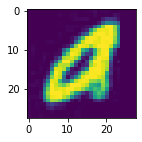

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(pic[:,:,0])
plt.show()

## Основные задания

Ваша задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

### Задание 1  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
При моделировании необходимо попробовать разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д. Оцените качество моделей с различными параметрами, проведите сравнительный анализ. 
2. Для наилучшей модели постройте confusion matrix результатов предсказаний модели на тестовых данных.  
Насколько равномерно обучилась ваша модель? Приведите буквы с самой лучшей и с самой худшей точностью детекции.
3. Найдите 10 пар букв, которые чаще всего путаются между собой, дайте возможное объяснение. Приведите примеры с картинками, которые были детектированы с ошибкой.
4. Возьмите первую букву вашей фамилии и укажите её точность детекции. С какими буквами ваша модель чаще всего путает эту букву?     

In [5]:
import os
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import random
import string
alphabet = string.ascii_lowercase

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [7]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [8]:
def get_dataset(path):
    x, y = [], []
    for dir, subdir, files in os.walk(path):
        try:
            letter = dir.split("/")[1]
        except IndexError:
            pass
        else:
            y += [letter] * len(files)
        x += [os.path.join(dir, file) for file in files]
    return x, y


x_train, y_train = get_dataset("train")
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
x_test, y_test = get_dataset("test")

In [9]:
class Dataset(torch.utils.data.Dataset): 
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        pic = plt.imread(self.x[idx])
        x = torch.tensor(np.transpose(pic, axes=(1, 0, 2))[:,:,0])
        y = torch.tensor(alphabet.index(self.y[idx]), dtype=torch.long)
        if self.transform:
            x = self.transform(x)
        return x, y

In [10]:
traintransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
        lambda x: torch.reshape(x, (-1, 28*28))
    ])

In [11]:
ds_train = Dataset(x_train, y_train, traintransform)
ds_val = Dataset(x_val, y_val, traintransform)
ds_test = Dataset(x_test, y_test, traintransform)

In [12]:
batch_size=500

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size)

In [13]:
class TwoDenseModel(nn.Module):
    def __init__(self):
        super(TwoDenseModel, self).__init__()
        pic_shape = 28*28
        self.input = nn.Linear(pic_shape, round(pic_shape*0.75))

        self.dense1 = nn.Linear(round(pic_shape*0.75), round(pic_shape*0.5))
        self.dense2 = nn.Linear(round(pic_shape*0.5), round(pic_shape*0.25))

        self.output = nn.Linear(round(pic_shape*0.25), 26)
    
    def forward(self, X):
        X = F.relu(self.input(X))

        X = F.relu(self.dense1(X))
        X = F.relu(self.dense2(X))

        return self.output(X)


In [14]:
class ThreeDenseModel(nn.Module):
    def __init__(self):
        super(ThreeDenseModel, self).__init__()
        pic_shape = 28*28
        self.input = nn.Linear(pic_shape, round(pic_shape*0.6))

        self.dense1 = nn.Linear(round(pic_shape*0.6), round(pic_shape*0.4))
        self.dense2 = nn.Linear(round(pic_shape*0.4), round(pic_shape*0.25))
        self.dense3 = nn.Linear(round(pic_shape*0.25), round(pic_shape*0.1))

        self.output = nn.Linear(round(pic_shape*0.1), 26)
    
    def forward(self, X):
        X = F.relu(self.input(X))

        X = F.relu(self.dense1(X))
        X = F.relu(self.dense2(X))
        X = F.relu(self.dense3(X))

        return self.output(X)

In [15]:
two_dense_model = TwoDenseModel()
two_dense_model.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(two_dense_model.parameters(), lr=5e-4)

In [16]:
def get_accuracy(y, y_predict):
    accuracy_list = y == torch.argmax(y_predict, dim=1)
    count_true_answers = accuracy_list.sum().float()
    accuracy = count_true_answers / y.size()[0]
    return accuracy, accuracy_list

In [17]:
def train_loop(model, epochs, train_dataloader, val_dataloader, save_best_model=False, epoch_print_frequency=1):
    log = {'loss': {'train': [], 'val': []},
           'accuracy': {'train': [], 'val': []}, 
           'best_epoch': None}

    model.to(device)
    accuracy_list = []
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device)

            y_predict = model(X).view(-1, 26)
            
#             print(y_predict.view(-1, 26), y)
            
            loss = loss_f(y_predict, y)
            accuracy_list += get_accuracy(y, y_predict)[1].cpu().tolist()
        
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        log['accuracy']['train'].append(sum(accuracy_list)/len(accuracy_list))
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        accuracy_list = []
        for X, y in val_dataloader:

            X, y = X.to(device), y.to(device)

            y_predicted = model(X).view(-1,26)

            loss = loss_f(y_predicted, y)
            running_loss += loss.item()
            
            accuracy_list += get_accuracy(y, y_predicted)[1].cpu().tolist()

        log['accuracy']['val'].append(sum(accuracy_list)/len(accuracy_list))
        log['loss']['val'].append(running_loss/len(val_dataloader))
        
        if not log['best_epoch'] or log['accuracy']['val'][-1] > max(log['accuracy']['val'][:-1]):
            if save_best_model:
                torch.save(model.state_dict(), 'best_model.pt')
            log['best_epoch'] = epoch
        if not epoch % epoch_print_frequency:
            print(f"Epoch: {epoch} / {epochs} | Train Accuracy: {log['accuracy']['train'][-1]:.3f}| Train loss: {log['loss']['train'][-1]:.3f} Val Accuracy: {log['accuracy']['val'][-1]:.3f} | Val loss: {log['loss']['val'][-1]:.3f}")
            
    return log

In [18]:
def test_model(model, dl_test):
    model.eval()
    log = {}
    log['predictions']=[]
    log['y']=[]
    accuracy_list = []
    for X, y in dl_test:
        X, y = X.to(device), y.to(device)
        y_p = model(X).view(-1, 26)
        
        log['y'].append(y.cpu())

        log['predictions'].append(y_p.data.cpu())
    
        accuracy_list += get_accuracy(y, y_p)[1].cpu().tolist()

    log['accuracy'] = sum(accuracy_list)/len(accuracy_list)
    log["y"] = torch.cat(log['y'])
    log['predictions'] = torch.cat(log['predictions'])
    return log

In [19]:
%%time
log = train_loop(two_dense_model, 20, dl_train, dl_val)

Epoch: 0 / 20 | Train Accuracy: 0.499| Train loss: 1.787 Val Accuracy: 0.649 | Val loss: 1.172
Epoch: 1 / 20 | Train Accuracy: 0.697| Train loss: 0.965 Val Accuracy: 0.752 | Val loss: 0.833
Epoch: 2 / 20 | Train Accuracy: 0.782| Train loss: 0.704 Val Accuracy: 0.807 | Val loss: 0.648
Epoch: 3 / 20 | Train Accuracy: 0.825| Train loss: 0.562 Val Accuracy: 0.833 | Val loss: 0.550
Epoch: 4 / 20 | Train Accuracy: 0.849| Train loss: 0.473 Val Accuracy: 0.846 | Val loss: 0.501
Epoch: 5 / 20 | Train Accuracy: 0.866| Train loss: 0.414 Val Accuracy: 0.862 | Val loss: 0.450
Epoch: 6 / 20 | Train Accuracy: 0.878| Train loss: 0.373 Val Accuracy: 0.868 | Val loss: 0.429
Epoch: 7 / 20 | Train Accuracy: 0.888| Train loss: 0.334 Val Accuracy: 0.876 | Val loss: 0.402
Epoch: 8 / 20 | Train Accuracy: 0.897| Train loss: 0.302 Val Accuracy: 0.884 | Val loss: 0.382
Epoch: 9 / 20 | Train Accuracy: 0.905| Train loss: 0.277 Val Accuracy: 0.880 | Val loss: 0.384
Epoch: 10 / 20 | Train Accuracy: 0.907| Train loss

In [23]:
def print_plot(log):
    fig, axs = plt.subplots(2,1,figsize=(20,10))
    

    axs[1].plot(range(len(log['loss']['train'])), log['loss']['train'], 'b', label="train")
    axs[1].plot(range(len(log['loss']['val'])), log['loss']['val'], 'r', label="val")
    axs[1].set_title('Loss')
    axs[0].plot(range(len(log['accuracy']['train'])), log['accuracy']['train'], 'b', label="train")
    axs[0].plot(range(len(log['accuracy']['val'])), log['accuracy']['val'], 'r', label="val")
    axs[0].set_title('Accuracy')
    axs[1].legend(loc="upper left",prop={'size': 20})
    axs[0].legend(loc="upper left",prop={'size': 20})
    
    fig.show()

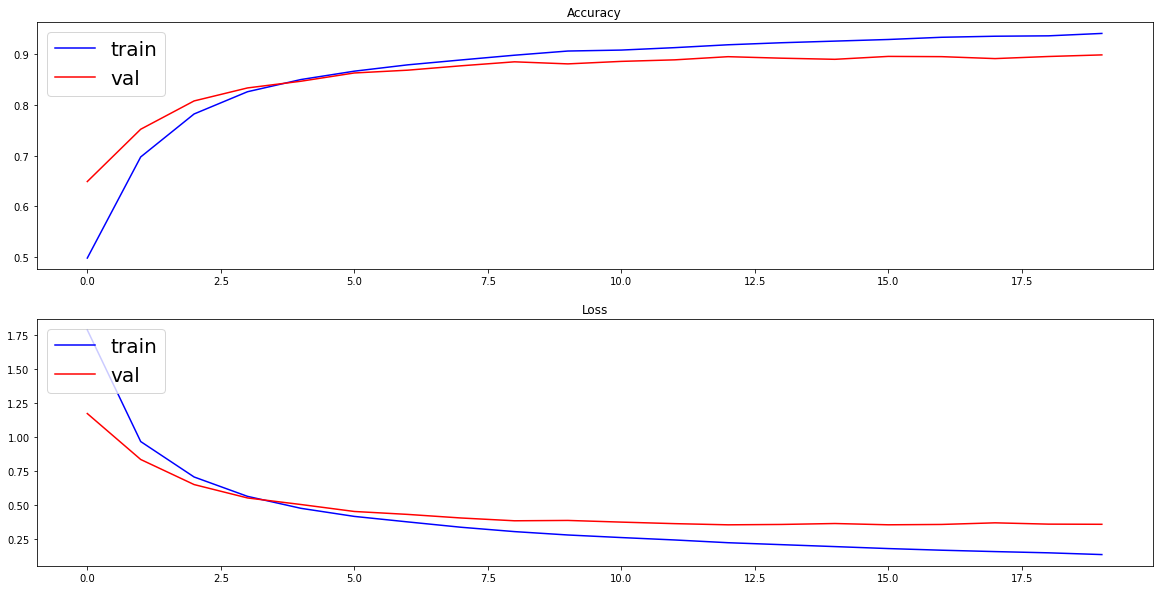

In [24]:
print_plot(log)

In [25]:
three_dense_model = ThreeDenseModel()
three_dense_model.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(three_dense_model.parameters(), lr=5e-4)

In [26]:
%%time
log_three_dense = train_loop(three_dense_model, 20, dl_train, dl_val)

Epoch: 0 / 20 | Train Accuracy: 0.388| Train loss: 2.116 Val Accuracy: 0.582 | Val loss: 1.383
Epoch: 1 / 20 | Train Accuracy: 0.624| Train loss: 1.201 Val Accuracy: 0.675 | Val loss: 1.085
Epoch: 2 / 20 | Train Accuracy: 0.712| Train loss: 0.922 Val Accuracy: 0.752 | Val loss: 0.826
Epoch: 3 / 20 | Train Accuracy: 0.771| Train loss: 0.728 Val Accuracy: 0.787 | Val loss: 0.696
Epoch: 4 / 20 | Train Accuracy: 0.808| Train loss: 0.606 Val Accuracy: 0.817 | Val loss: 0.607
Epoch: 5 / 20 | Train Accuracy: 0.834| Train loss: 0.526 Val Accuracy: 0.832 | Val loss: 0.554
Epoch: 6 / 20 | Train Accuracy: 0.852| Train loss: 0.461 Val Accuracy: 0.841 | Val loss: 0.506
Epoch: 7 / 20 | Train Accuracy: 0.863| Train loss: 0.418 Val Accuracy: 0.858 | Val loss: 0.470
Epoch: 8 / 20 | Train Accuracy: 0.874| Train loss: 0.384 Val Accuracy: 0.857 | Val loss: 0.461
Epoch: 9 / 20 | Train Accuracy: 0.879| Train loss: 0.356 Val Accuracy: 0.866 | Val loss: 0.438
Epoch: 10 / 20 | Train Accuracy: 0.889| Train loss

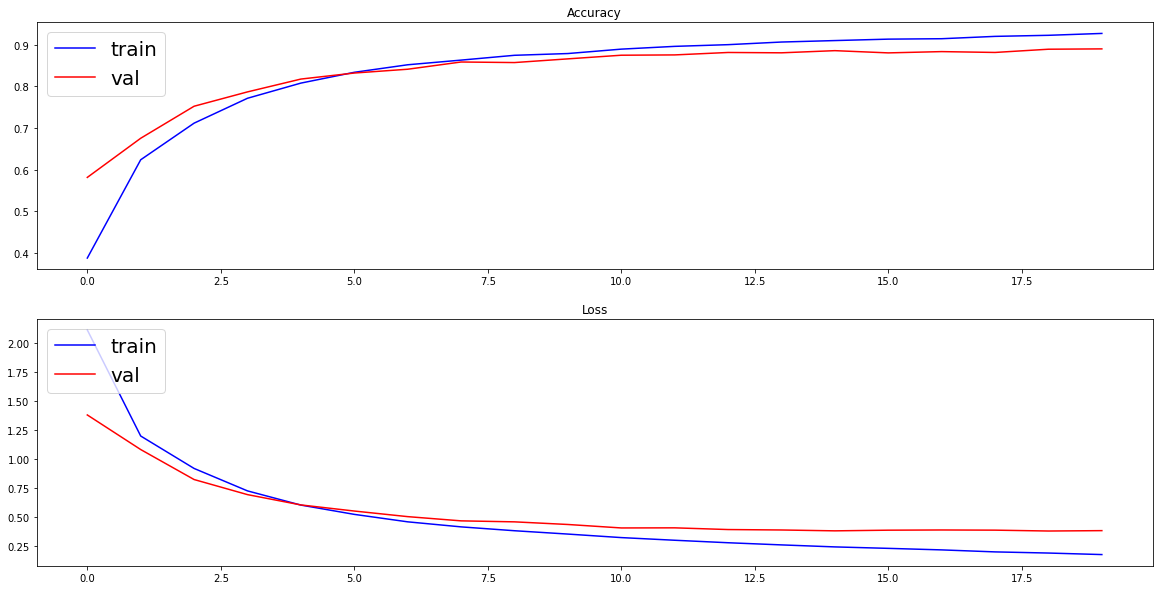

In [27]:
print_plot(log_three_dense)

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
three_dense_log = test_model(three_dense_model, dl_test)
two_dense_log = test_model(two_dense_model, dl_test)

In [30]:
three_dense_log['accuracy']

0.8866153846153846

In [31]:
two_dense_log['accuracy']

0.8980769230769231

Как можно заметить, модель с меньшим количеством слоёв, как ни странно обучилась лучше, чем с бОльшим. Это обусловлено тем, что новыслой вносит больше хаоса, чем пользы на данном датасете.

In [32]:
two_dense_log['predictions'] = list(map(torch.argmax, two_dense_log['predictions']))

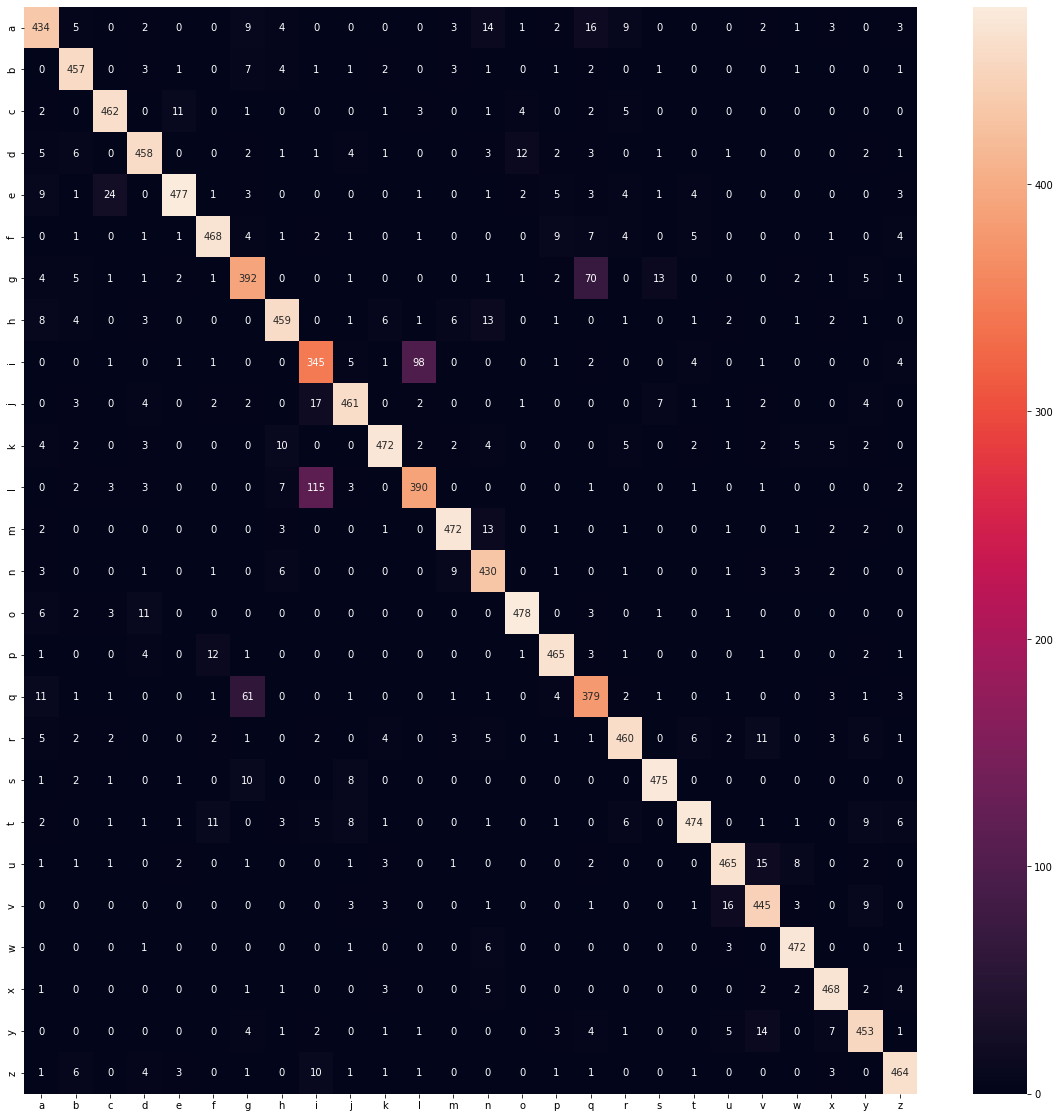

In [33]:
cf_mat = confusion_matrix(two_dense_log['predictions'], two_dense_log['y'])
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(cf_mat, annot=True, xticklabels=string.ascii_lowercase, yticklabels=string.ascii_lowercase, fmt='g')

можно заметить, что в целом модель обучилась достаточно равномерно.
Чаще всего проблемы возникали с буквами l и i.
На втором месте оказалась пара букв g и q.

Самыми худшими оказались буквы: q(367), i(338), l(379)
Однако, что странно лучшими буквами оказались j(470) и w(469).

In [34]:
a = np.array([i for i in string.ascii_lowercase])
k = {}
for i, row in enumerate(cf_mat):
    max_ind = (-row).argsort()[1:3]
    for j in max_ind:
        v = row[j]
        i, j = (i, j) if i < j else (j, i)
        val = k.get(f"{a[i]} {a[j]}")
        if val is None:
            k[f"{a[i]} {a[j]}"] = v
        else:
            k[f"{a[i]} {a[j]}"] += v
# print(k.items())
print('\n'.join(map(lambda x: f"{x[0]} {x[1]}", sorted(k.items(), key=lambda x:x[1], reverse=True)[:10])))

i l 213
g q 131
c e 35
u v 31
d o 23
g s 23
i j 22
m n 22
f p 21
a q 16


In [35]:
def get_bad_predicted(a, b):
    real_ind = 0
    for ind, i in enumerate(two_dense_log['y']):
        l_ind = string.ascii_lowercase.index(a)
        i_ind = string.ascii_lowercase.index(b)
        if i == l_ind and two_dense_log['predictions'][ind] == i_ind:
            real_ind = ind
            break
    plt.figure(figsize=(5,5))
    # print(ds_test[real_ind])
    plt.imshow(ds_test[real_ind][0].reshape(28,28))
    plt.text(1, 1, f"Должна быть: {a}\nПредсказалась: {b}", bbox={'facecolor': 'white', 'pad': 5})
#     plt.set_label(f"Должна быть: {a}\nПредсказалась: {b}")
    plt.show()

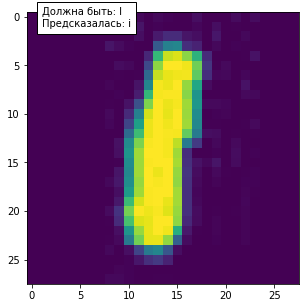

In [36]:
get_bad_predicted('l', 'i')

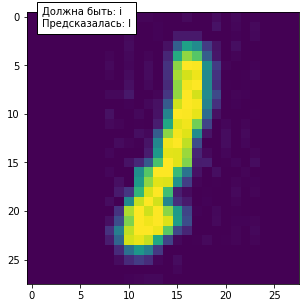

In [37]:
get_bad_predicted('i', 'l')

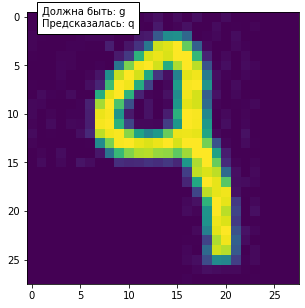

In [38]:
get_bad_predicted('g', 'q')

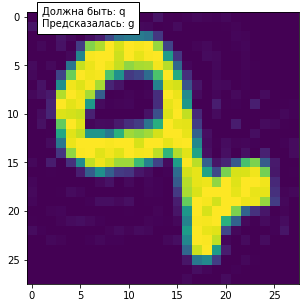

In [39]:
get_bad_predicted('q', 'g')

Пара l и i является абсолютным рекордсменом. 

Первая буква моей фамилии - S (Shatilov)

In [40]:
s_ind = string.ascii_lowercase.index('s')
print(cf_mat[s_ind][s_ind]/5, "% - процент правильности выбора этой буквы")

95.0 % - процент правильности выбора этой буквы


In [41]:
s_sum = cf_mat[:,s_ind]

In [42]:
index_bad_pred = (-s_sum).argsort()[1:4]
print(dict(zip(a[index_bad_pred], s_sum[index_bad_pred])))

{'g': 13, 'j': 7, 'b': 1}


### Задание 2  
  
*Вес в общей оценке - 0.35*  
  
1. Постройте и обучите модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Попробуйте различные значения параметров сверток и числа фильтров на каждом слое. Оцените качество моделей с различными параметрами, проведите сравнительный анализ.  
2. Для наилучшей конфигурации из предыдущего пункта, сравните, как меняется качество модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

In [43]:
class OneConvalModel(nn.Module):
    def __init__(self):
        super(OneConvalModel, self).__init__()
        self.conval1 = nn.Conv2d(1, 5, 3)
        self.output = nn.Linear(5*26*26, 26)
    
    def forward(self, X):
        X = F.relu(self.conval1(X))

        return self.output(X.reshape(-1, 5*26*26))

In [44]:
class TwoConvalModel(nn.Module):
    def __init__(self):
        super(TwoConvalModel, self).__init__()
        self.conval1 = nn.Conv2d(1, 5, 3)
        self.conval2 = nn.Conv2d(5, 7, 3)
        self.output = nn.Linear(7*24*24, 26)
    
    def forward(self, X):
        X = F.relu(self.conval1(X))
        X = F.relu(self.conval2(X))

        return self.output(X.reshape(-1, 7*24*24))

In [45]:
class ThreeConvalModel(nn.Module):
    def __init__(self):
        super(ThreeConvalModel, self).__init__()
        self.conval1 = nn.Conv2d(1, 5, 3)
        self.conval2 = nn.Conv2d(5, 7, 3)
        self.conval3 = nn.Conv2d(7, 10, 3)
        self.output = nn.Linear(10*22*22, 26)
    
    def forward(self, X):
        X = F.relu(self.conval1(X))
        X = F.relu(self.conval2(X))
        X = F.relu(self.conval3(X))

        return self.output(X.reshape(-1, 10*22*22))

In [46]:
traintransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

In [47]:
ds_train = Dataset(x_train, y_train, traintransform)
ds_val = Dataset(x_val, y_val, traintransform)
ds_test = Dataset(x_test, y_test, traintransform)

In [48]:
batch_size=250

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size)

In [49]:
one_conval_model = OneConvalModel()
one_conval_model.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(one_conval_model.parameters(), lr=5e-4)

Epoch: 0 / 20 | Train Accuracy: 0.571| Train loss: 1.679 Val Accuracy: 0.672 | Val loss: 1.147
Epoch: 1 / 20 | Train Accuracy: 0.693| Train loss: 1.038 Val Accuracy: 0.713 | Val loss: 1.006
Epoch: 2 / 20 | Train Accuracy: 0.727| Train loss: 0.934 Val Accuracy: 0.735 | Val loss: 0.930
Epoch: 3 / 20 | Train Accuracy: 0.748| Train loss: 0.857 Val Accuracy: 0.751 | Val loss: 0.863
Epoch: 4 / 20 | Train Accuracy: 0.767| Train loss: 0.788 Val Accuracy: 0.765 | Val loss: 0.816
Epoch: 5 / 20 | Train Accuracy: 0.781| Train loss: 0.735 Val Accuracy: 0.778 | Val loss: 0.769
Epoch: 6 / 20 | Train Accuracy: 0.795| Train loss: 0.688 Val Accuracy: 0.787 | Val loss: 0.730
Epoch: 7 / 20 | Train Accuracy: 0.804| Train loss: 0.653 Val Accuracy: 0.796 | Val loss: 0.703
Epoch: 8 / 20 | Train Accuracy: 0.813| Train loss: 0.623 Val Accuracy: 0.799 | Val loss: 0.682
Epoch: 9 / 20 | Train Accuracy: 0.819| Train loss: 0.597 Val Accuracy: 0.805 | Val loss: 0.663
Epoch: 10 / 20 | Train Accuracy: 0.826| Train loss

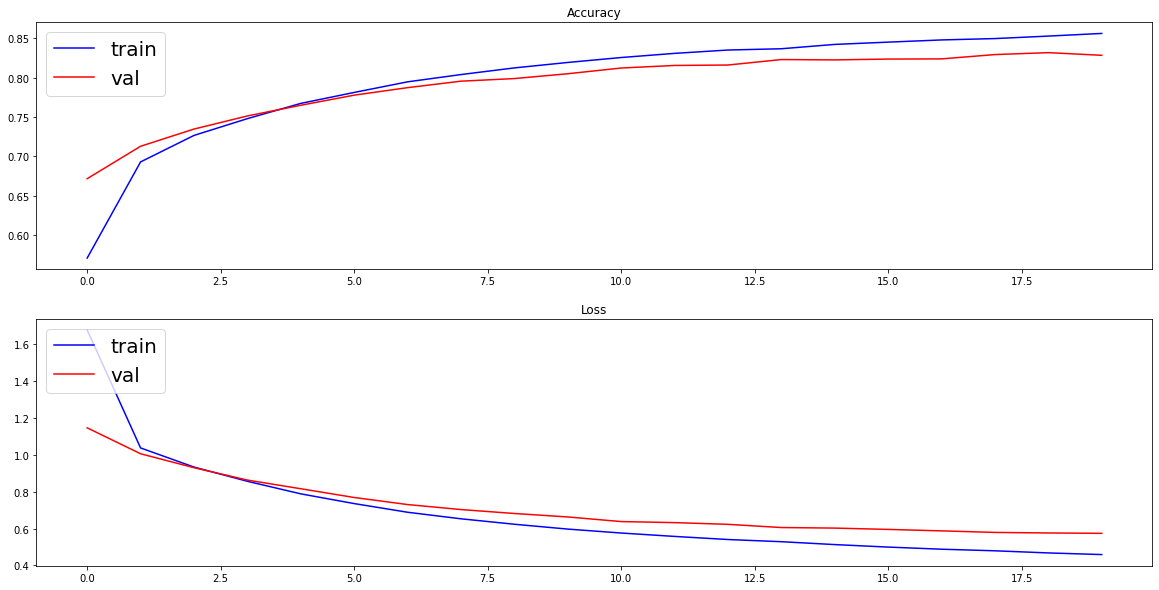

In [50]:
%%time
log = train_loop(one_conval_model, 20, dl_train, dl_val)
print_plot(log)
one_conval_model_log = test_model(one_conval_model, dl_test)
print("Accuracy:", one_conval_model_log["accuracy"])

In [51]:
two_conval_model = TwoConvalModel()
two_conval_model.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(two_conval_model.parameters(), lr=5e-4)

Epoch: 0 / 20 | Train Accuracy: 0.639| Train loss: 1.361 Val Accuracy: 0.712 | Val loss: 0.996
Epoch: 1 / 20 | Train Accuracy: 0.740| Train loss: 0.862 Val Accuracy: 0.771 | Val loss: 0.795
Epoch: 2 / 20 | Train Accuracy: 0.792| Train loss: 0.690 Val Accuracy: 0.811 | Val loss: 0.660
Epoch: 3 / 20 | Train Accuracy: 0.824| Train loss: 0.583 Val Accuracy: 0.829 | Val loss: 0.586
Epoch: 4 / 20 | Train Accuracy: 0.843| Train loss: 0.518 Val Accuracy: 0.840 | Val loss: 0.543
Epoch: 5 / 20 | Train Accuracy: 0.852| Train loss: 0.478 Val Accuracy: 0.850 | Val loss: 0.509
Epoch: 6 / 20 | Train Accuracy: 0.862| Train loss: 0.446 Val Accuracy: 0.855 | Val loss: 0.489
Epoch: 7 / 20 | Train Accuracy: 0.867| Train loss: 0.424 Val Accuracy: 0.862 | Val loss: 0.472
Epoch: 8 / 20 | Train Accuracy: 0.874| Train loss: 0.404 Val Accuracy: 0.864 | Val loss: 0.458
Epoch: 9 / 20 | Train Accuracy: 0.878| Train loss: 0.385 Val Accuracy: 0.866 | Val loss: 0.454
Epoch: 10 / 20 | Train Accuracy: 0.882| Train loss

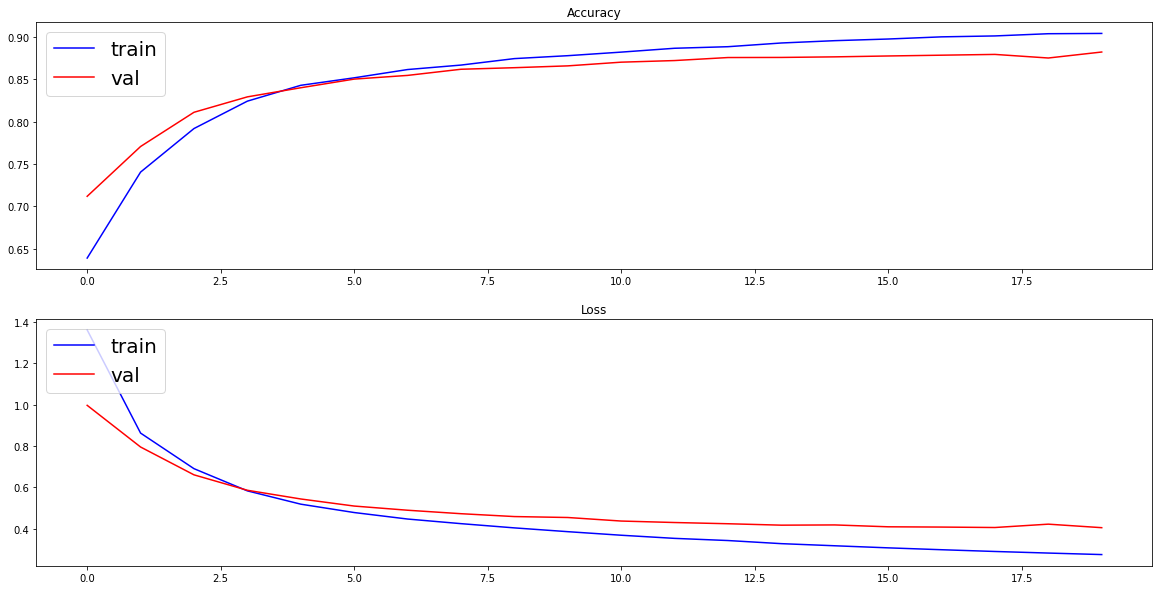

In [53]:
%%time
log = train_loop(two_conval_model, 20, dl_train, dl_val)
print_plot(log)
two_conval_model_log = test_model(two_conval_model, dl_test)
print("Accuracy:", two_conval_model_log["accuracy"])

In [54]:
three_conval_model = ThreeConvalModel()
three_conval_model.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(three_conval_model.parameters(), lr=5e-4)

Epoch: 0 / 15 | Train Accuracy: 0.576| Train loss: 1.561 Val Accuracy: 0.693 | Val loss: 1.064
Epoch: 1 / 15 | Train Accuracy: 0.731| Train loss: 0.885 Val Accuracy: 0.774 | Val loss: 0.762
Epoch: 2 / 15 | Train Accuracy: 0.805| Train loss: 0.632 Val Accuracy: 0.829 | Val loss: 0.583
Epoch: 3 / 15 | Train Accuracy: 0.844| Train loss: 0.509 Val Accuracy: 0.844 | Val loss: 0.527
Epoch: 4 / 15 | Train Accuracy: 0.856| Train loss: 0.458 Val Accuracy: 0.855 | Val loss: 0.486
Epoch: 5 / 15 | Train Accuracy: 0.867| Train loss: 0.422 Val Accuracy: 0.861 | Val loss: 0.466
Epoch: 6 / 15 | Train Accuracy: 0.874| Train loss: 0.397 Val Accuracy: 0.866 | Val loss: 0.457
Epoch: 7 / 15 | Train Accuracy: 0.879| Train loss: 0.379 Val Accuracy: 0.867 | Val loss: 0.454
Epoch: 8 / 15 | Train Accuracy: 0.882| Train loss: 0.365 Val Accuracy: 0.862 | Val loss: 0.456
Epoch: 9 / 15 | Train Accuracy: 0.883| Train loss: 0.351 Val Accuracy: 0.864 | Val loss: 0.449
Epoch: 10 / 15 | Train Accuracy: 0.887| Train loss

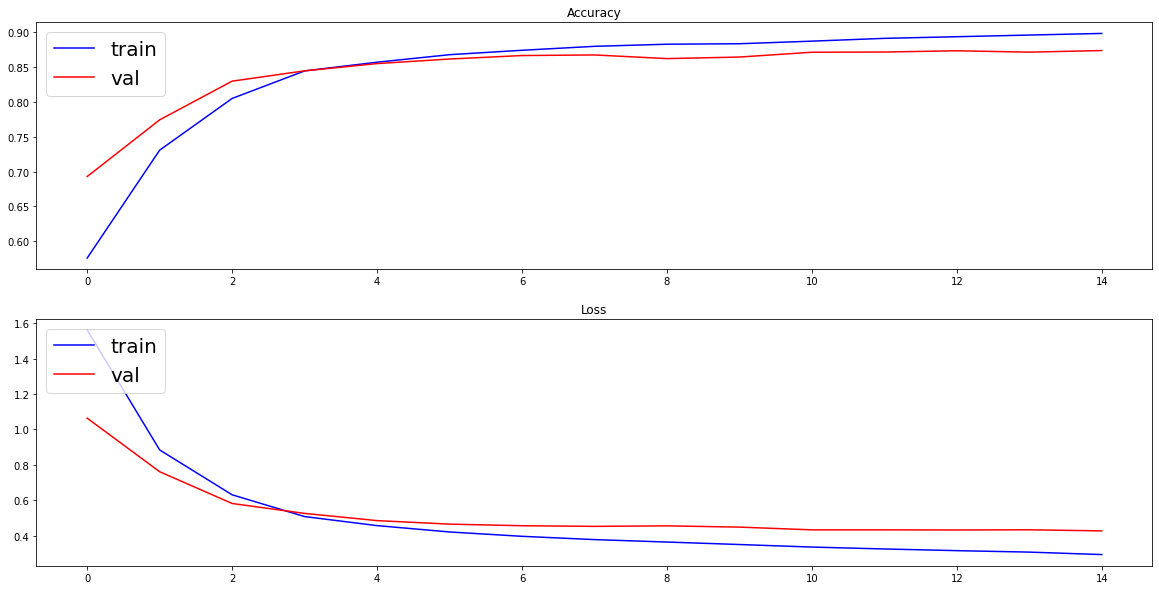

In [55]:
%%time
log = train_loop(three_conval_model, 15, dl_train, dl_val)
print_plot(log)
three_conval_model_log = test_model(three_conval_model, dl_test)
print("Accuracy:", three_conval_model_log["accuracy"])

Получилась лучшая моделька - 3.

In [57]:
class ThreeConvalModelBN(nn.Module):
    def __init__(self):
        super(ThreeConvalModelBN, self).__init__()
        self.conval1 = nn.Conv2d(1, 5, 3)
        self.conv1_bn=nn.BatchNorm2d(5)
        self.conval2 = nn.Conv2d(5, 7, 3)
        self.conv2_bn=nn.BatchNorm2d(7)
        self.conval3 = nn.Conv2d(7, 10, 3)
        self.conv2_bn=nn.BatchNorm2d(10)
        
        self.output = nn.Linear(10*22*22, 26)
    
    def forward(self, X):
        X = F.relu(self.conval1(X))
        X = F.relu(self.conval2(X))
        X = F.relu(self.conval3(X))

        return self.output(X.reshape(-1, 10*22*22))

In [58]:
class ThreeConvalModelGN(nn.Module):
    def __init__(self):
        super(ThreeConvalModelGN, self).__init__()
        self.conval1 = nn.Conv2d(1, 5, 3)
        self.conv1_bn=nn.GroupNorm(2, 5)
        self.conval2 = nn.Conv2d(5, 7, 3)
        self.conv2_bn=nn.GroupNorm(3, 7)
        self.conval3 = nn.Conv2d(7, 10, 3)
        self.conv2_bn=nn.GroupNorm(5, 10)
        
        self.output = nn.Linear(10*22*22, 26)
    
    def forward(self, X):
        X = F.relu(self.conval1(X))
        X = F.relu(self.conval2(X))
        X = F.relu(self.conval3(X))

        return self.output(X.reshape(-1, 10*22*22))

In [59]:
three_conval_model_bn = ThreeConvalModelBN()
three_conval_model_bn.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(three_conval_model_bn.parameters(), lr=5e-4)

Epoch: 0 / 15 | Train Accuracy: 0.598| Train loss: 1.460 Val Accuracy: 0.687 | Val loss: 1.073
Epoch: 1 / 15 | Train Accuracy: 0.712| Train loss: 0.959 Val Accuracy: 0.743 | Val loss: 0.894
Epoch: 2 / 15 | Train Accuracy: 0.775| Train loss: 0.738 Val Accuracy: 0.807 | Val loss: 0.671
Epoch: 3 / 15 | Train Accuracy: 0.824| Train loss: 0.570 Val Accuracy: 0.831 | Val loss: 0.560
Epoch: 4 / 15 | Train Accuracy: 0.847| Train loss: 0.492 Val Accuracy: 0.851 | Val loss: 0.510
Epoch: 5 / 15 | Train Accuracy: 0.862| Train loss: 0.446 Val Accuracy: 0.860 | Val loss: 0.478
Epoch: 6 / 15 | Train Accuracy: 0.869| Train loss: 0.416 Val Accuracy: 0.862 | Val loss: 0.461
Epoch: 7 / 15 | Train Accuracy: 0.876| Train loss: 0.390 Val Accuracy: 0.867 | Val loss: 0.441
Epoch: 8 / 15 | Train Accuracy: 0.881| Train loss: 0.374 Val Accuracy: 0.873 | Val loss: 0.424
Epoch: 9 / 15 | Train Accuracy: 0.886| Train loss: 0.355 Val Accuracy: 0.871 | Val loss: 0.424
Epoch: 10 / 15 | Train Accuracy: 0.890| Train loss

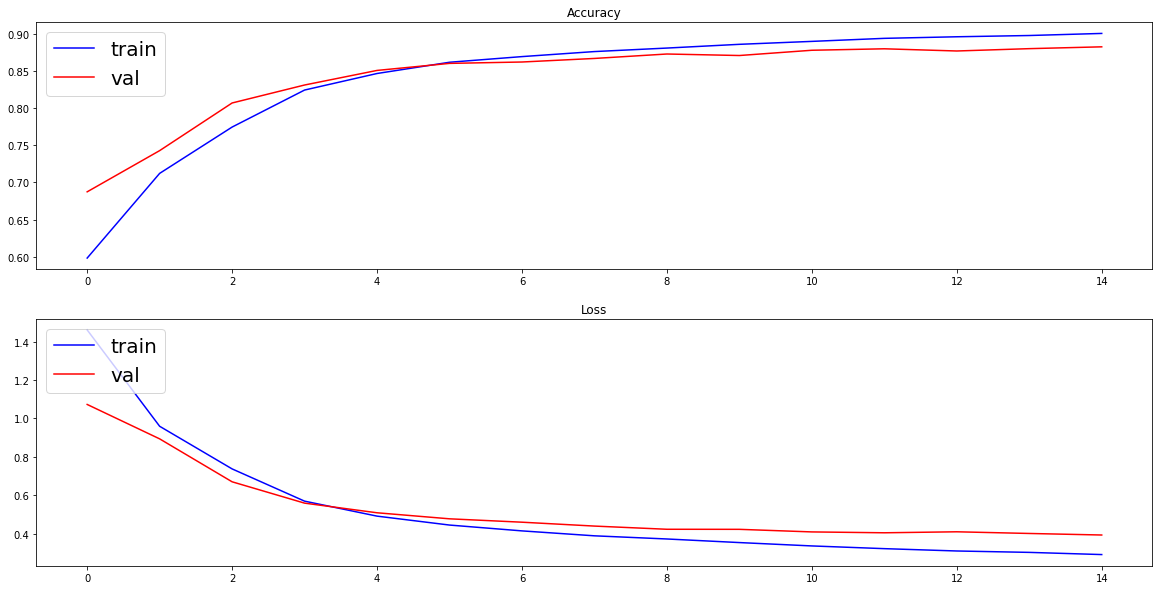

In [60]:
%%time
log = train_loop(three_conval_model_bn, 15, dl_train, dl_val)
print_plot(log)
three_conval_model_bn_log = test_model(three_conval_model_bn, dl_test)
print("Accuracy:", three_conval_model_bn_log["accuracy"])

In [61]:
three_conval_model_gn = ThreeConvalModelBN()
three_conval_model_gn.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(three_conval_model_gn.parameters(), lr=5e-4)

Epoch: 0 / 15 | Train Accuracy: 0.556| Train loss: 1.625 Val Accuracy: 0.681 | Val loss: 1.094
Epoch: 1 / 15 | Train Accuracy: 0.705| Train loss: 0.983 Val Accuracy: 0.723 | Val loss: 0.939
Epoch: 2 / 15 | Train Accuracy: 0.752| Train loss: 0.819 Val Accuracy: 0.777 | Val loss: 0.763
Epoch: 3 / 15 | Train Accuracy: 0.804| Train loss: 0.631 Val Accuracy: 0.822 | Val loss: 0.602
Epoch: 4 / 15 | Train Accuracy: 0.839| Train loss: 0.512 Val Accuracy: 0.846 | Val loss: 0.516
Epoch: 5 / 15 | Train Accuracy: 0.859| Train loss: 0.451 Val Accuracy: 0.859 | Val loss: 0.468
Epoch: 6 / 15 | Train Accuracy: 0.870| Train loss: 0.414 Val Accuracy: 0.865 | Val loss: 0.451
Epoch: 7 / 15 | Train Accuracy: 0.876| Train loss: 0.388 Val Accuracy: 0.870 | Val loss: 0.439
Epoch: 8 / 15 | Train Accuracy: 0.880| Train loss: 0.371 Val Accuracy: 0.876 | Val loss: 0.424
Epoch: 9 / 15 | Train Accuracy: 0.885| Train loss: 0.355 Val Accuracy: 0.874 | Val loss: 0.420
Epoch: 10 / 15 | Train Accuracy: 0.888| Train loss

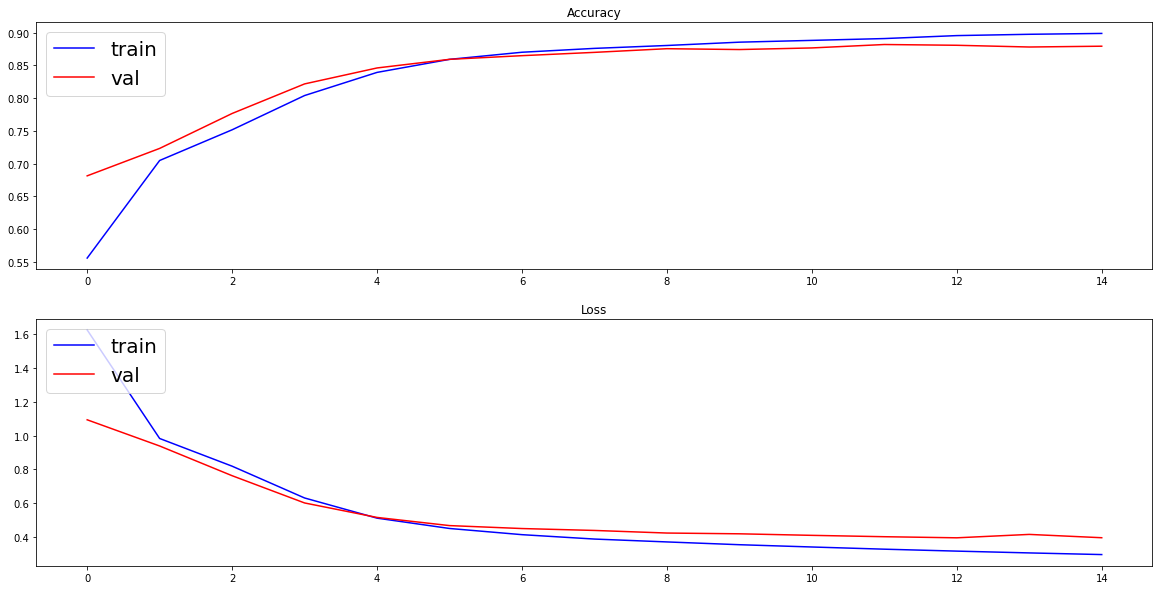

In [62]:
%%time
log = train_loop(three_conval_model_gn, 15, dl_train, dl_val)
print_plot(log)
three_conval_model_gn_log = test_model(three_conval_model_gn, dl_test)
print("Accuracy:", three_conval_model_gn_log["accuracy"])

In [63]:
batch_size=100

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size)

In [74]:
del three_conval_model_gn

In [75]:
three_conval_model_gn = ThreeConvalModelBN()
three_conval_model_gn.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(three_conval_model_gn.parameters(), lr=5e-4)

Epoch: 0 / 2 | Train Accuracy: 0.917| Train loss: 0.267 Val Accuracy: 0.883 | Val loss: 0.394
Epoch: 1 / 2 | Train Accuracy: 0.908| Train loss: 0.267 Val Accuracy: 0.883 | Val loss: 0.395
Accuracy: 0.8857692307692308
CPU times: user 2min 16s, sys: 4.11 s, total: 2min 20s
Wall time: 2min 20s


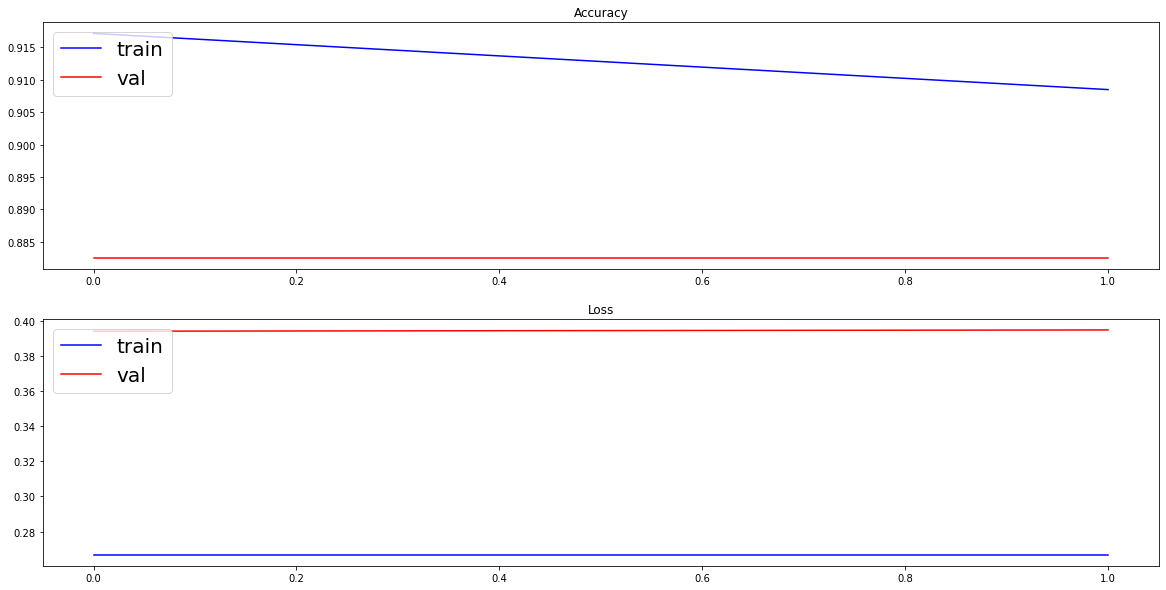

In [76]:
%%time
log = train_loop(three_conval_model_bn, 2, dl_train, dl_val)
print_plot(log)
three_conval_model_bn_log = test_model(three_conval_model_bn, dl_test)
print("Accuracy:", three_conval_model_bn_log["accuracy"])

In [65]:
batch_size=750

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size)

In [71]:
tthree_conval_model_gn = ThreeConvalModelBN()
three_conval_model_gn.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(three_conval_model_gn.parameters(), lr=5e-4)

Epoch: 0 / 2 | Train Accuracy: 0.917| Train loss: 0.267 Val Accuracy: 0.883 | Val loss: 0.394
Epoch: 1 / 2 | Train Accuracy: 0.908| Train loss: 0.267 Val Accuracy: 0.883 | Val loss: 0.392
Accuracy: 0.8857692307692308
CPU times: user 2min 15s, sys: 4.17 s, total: 2min 20s
Wall time: 2min 20s


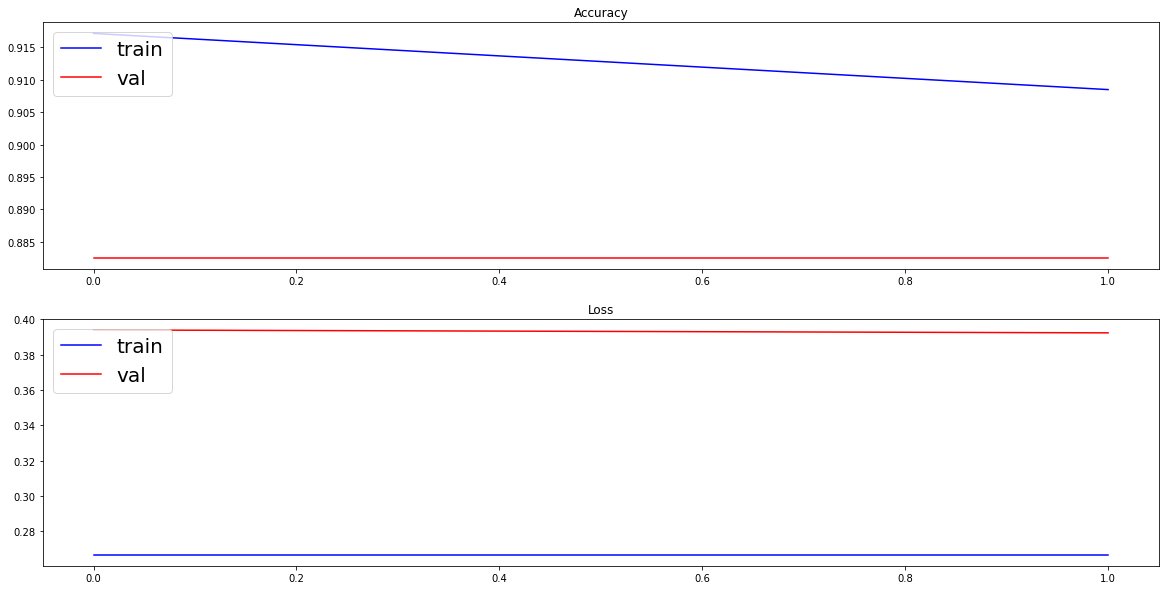

In [77]:
%%time
log = train_loop(three_conval_model_bn, 2, dl_train, dl_val)
print_plot(log)
three_conval_model_bn_log = test_model(three_conval_model_bn, dl_test)
print("Accuracy:", three_conval_model_bn_log["accuracy"])

При уменьшении batch_size увеличивается скорость обучения. 
BatchNorm и GroupNorm улучшают максимальный результат, которого можно достичь.

### Задание 3    
  
Обучите модель с точностью (accuracy) на тестовых данных:  
- `>= 0.85`    +1 балл
- `>= 0.95`    +2 балла
- `>= 0.99`    +3 балла  

In [78]:
class BestConvalModel(nn.Module):
    def __init__(self):
        super(BestConvalModel, self).__init__()
        self.dropout = nn.Dropout(0.25)
        
        self.conval1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv1_bn=nn.BatchNorm2d(16)
        self.conval2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_bn=nn.BatchNorm2d(32)
        self.conval3 = nn.Conv2d(32, 46, 3, padding=1)
        self.conv3_bn=nn.BatchNorm2d(46)
        self.conval4 = nn.Conv2d(46, 64, 3, padding=1)
        self.conv4_bn=nn.BatchNorm2d(64)
        self.conval5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5_bn=nn.BatchNorm2d(128)
        self.output = nn.Linear(128*3*3, 26)
    
    def forward(self, X):
        X = self.conval1(X)
        X = F.relu(self.conv1_bn(X))
        X = F.max_pool2d(X, kernel_size=2)
        
        X = self.conval2(X)
        X = F.relu(self.conv2_bn(X))
#         X = F.max_pool2d(X, kernel_size=2)
        
        X = self.conval3(X)
        X = F.relu(self.conv3_bn(X))
        X = F.max_pool2d(X, kernel_size=2)
        X = self.dropout(X)
        
        X = self.conval4(X)
        X = F.relu(self.conv4_bn(X))
#         X = F.max_pool2d(X, kernel_size=2)
        
        X = self.conval5(X)
        X = F.relu(self.conv5_bn(X))
        X = F.max_pool2d(X, kernel_size=2)
        X = self.dropout(X)
        
#         Y = F.softmax(self.output(X), dim=1)
#         print(X.size())
        return self.output(X.reshape(-1, 128*3*3))

In [79]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [80]:
traintransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomApply([AddGaussianNoise()], p=0.5),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 5))], p=0.5)
    ])

In [81]:
testtransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

In [82]:
ds_train = Dataset(x_train, y_train, traintransform)
ds_val = Dataset(x_val, y_val, testtransform)
ds_test = Dataset(x_test, y_test, testtransform)

In [83]:
batch_size=128

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size)
dl_test = DataLoader(ds_test, batch_size=batch_size)

In [84]:
model = BestConvalModel()
model.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
%%time
log = train_loop(model, 35, dl_train, dl_val, save_best_model=True, epoch_print_frequency=1)

[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch: 0 / 35 | Train Accuracy: 0.448| Train loss: 1.969 Val Accuracy: 0.760 | Val loss: 0.828
Epoch: 1 / 35 | Train Accuracy: 0.748| Train loss: 0.851 Val Accuracy: 0.847 | Val loss: 0.488


In [30]:
model = BestConvalModel()
model.load_state_dict(torch.load(f'best_model.pt'))
model.to(device)

BestConvalModel(
  (dropout): Dropout(p=0.25, inplace=False)
  (conval1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conval2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conval3): Conv2d(32, 46, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conval4): Conv2d(46, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conval5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=1152, out_features=26, bias=True)
)

In [31]:
# print_plot(log)
model_log = test_model(model, dl_test)
print("Accuracy:", model_log["accuracy"])

Accuracy: 0.9436153846153846


## Бонусные задания

**Задание 1 (1 балл).**  

Напишите на листке белой бумаги (маркером или ручкой) от 5 разных букв (можно больше 5 букв в целом с повторениями, но должно быть минимум 5 разных) английского алфавита (в датасете есть как прописные, так и строчные буквы). Сфотографируйте букву и приведите её картинку к размеру $28\times28$ и, желательно, к чёрно-белой палитре цветов. Передайте получившиеся изображения вашей модели и выполните предсказание, оцените результат.  
  
**Tips:**  
- В датасете все буквы занимают практически всё пространство картинки по высоте или ширине (или вместе). Если ваша буква будет слишком маленькой или большой, это может повлиять на результат детекции.
- Помните, что буква должна быть белого цвета, а фон - чёрного.
- Описание ваших действий при выполнении этого задания (что вы использовали, чтобы привести картинку к нужному виду) категорически приветствуется :)

**Задание 2 (1 балл):**    
  
Используйте transfer learning подход для решения задачи - дообучите какую-либо модель, предобученную на ImageNet, для классификации рукописных букв. Оцените качество решения.  
В качестве предобученой модели можно взять одну из [torchvision models](https://pytorch.org/vision/stable/models.html).

**Задание 3 (1 балл):**  
  
Добавьте вывод значений функции потерь и accuracy в tensorboard.  
Метрики нужно выводить и для обучающей, и для тестовой выборки.